
## 1. Load Preprocessed Dataset
- Load the preprocessed train, validation, and test datasets.


In [61]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))
from src.utils import visualization_utils as vu
from src.utils import dataset_utils as du
from src.utils import model_utils as mu


import tensorflow as tf
import tensorflow_datasets as tfds


# prevent TensorFlow from allocating all the GPU memory at the start
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

# Clear Keras session
import tensorflow.keras.backend as K
K.clear_session()

# Define data directories
base_dir = '/tf/projects/malaria-image-recognition/notebooks/'
data_dir = os.path.join(base_dir, 'data', 'raw')

# Load  dataset
datasets, _info = tfds.load('malaria',
                            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                            data_dir=data_dir,
                            shuffle_files=True,
                            download=False,  # Need not download again if already available in the localhost
                            as_supervised=True,
                            with_info=True)

train_dataset, val_dataset, test_dataset = datasets
print(_info)

# Print five random samples
print('\n\n Random samples from train_dataset: \n\n')
du.print_sample_info(test_dataset)



tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/tf/projects/malaria-image-recognition/notebooks/data/raw/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite 

2024-07-20 15:06:11.264597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
# Preprocess the dataset
train_dataset_preprocessed = du.preprocess_dataset(train_dataset, buffer_size=10000, batch_size=300)
val_dataset_preprocessed = du.preprocess_dataset(val_dataset, buffer_size=10000, batch_size=300)
test_dataset_preprocessed = du.preprocess_dataset(test_dataset, buffer_size=10000, batch_size=300)


In [4]:
# # After preprocessing
print("After preprocessing:")
print('\n\n Random samples from train_dataset after preprocessing:: \n\n')
du.print_sample_info(train_dataset_preprocessed)

After preprocessing:


 Random samples from train_dataset after preprocessing:: 


Sample 1:
Image shape: (300, 128, 128, 3)
Image size: 14745600
Image dimensions: 4
Label: [1 1 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1
 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1
 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0
 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0
 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0
 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0
 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0
 1 0 0 0]

Sample 2:
Image shape: (300, 128, 128, 3)
Image size: 14745600
Image dimensions: 4
Label: [1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1
 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 

2024-07-20 12:38:50.220881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



## 2. Define LeNet Model
- Define the LeNet architecture using TensorFlow/Keras.
- Add dropout layer for regularization.
- Compile the model with appropriate hyper-parameters.


In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, InputLayer, Dense, Dropout, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Accuracy


def lenet_model():
    model = tf.keras.Sequential([

        InputLayer(shape=(128, 128, 3)),
        
        Conv2D(6, (5, 5), activation='relu', padding='valid'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(.25),
        
        Conv2D(16, (5, 5), activation='relu', padding='valid'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(.25),
        
        tf.keras.layers.Flatten(),
                
        tf.keras.layers.Dense(120, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        tf.keras.layers.Dense(84, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid') 
    ],
       name = 'CNN-malaria-detection'
   )

    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=[BinaryAccuracy()])
    return model

model = lenet_model()
model.summary()

Model: "CNN-malaria-detection"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 124, 124, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 124, 124, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 62, 62, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 62, 62, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 58, 58, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 120)            │     1,614,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 120)            │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 84)             │           336 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,865 (6.21 MB)

 Trainable params: 1,628,413 (6.21 MB)

 Non-trainable params: 452 (1.77 KB)


## 3. Train Model
- Define necessary callbacks 
- Train the model on the training dataset.
- Validate the model on the validation dataset.

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1  
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1  
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.01,
    verbose=1  
)

tensorboard = TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

# Fit the model with the callbacks
history = model.fit(
    train_dataset_preprocessed,
    epochs=20,
    verbose=1,
    validation_data=val_dataset_preprocessed,
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard]
)


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - binary_accuracy: 0.6475 - loss: 0.6945
Epoch 1: val_loss improved from inf to 12.95786, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - binary_accuracy: 0.6485 - loss: 0.6928 - val_binary_accuracy: 0.4888 - val_loss: 12.9579 - learning_rate: 0.0100
Epoch 2/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - binary_accuracy: 0.9088 - loss: 0.2536
Epoch 2: val_loss improved from 12.95786 to 8.26428, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - binary_accuracy: 0.9090 - loss: 0.2530 - val_binary_accuracy: 0.4888 - val_loss: 8.2643 - learning_rate: 0.0100
Epoch 3/20
73/74 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - binary_accuracy: 0.9388 - loss: 0.1854
Epoch 3: val_loss improved from 8.26428 to 1.26488, saving model to best_model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - binary_accuracy: 0.9388 - loss: 0.1853 - val_binary_accuracy: 0.5341 - val_loss: 1.2649 - learning_rate: 0.0100
E


## 4. Evaluate Model
- Evaluate the model on the test dataset.

In [46]:
test_loss, test_acc = model.evaluate(test_dataset_preprocessed, verbose=1)
print(f"Test Accuracy:{test_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - binary_accuracy: 0.9574 - loss: 0.1451
Test Accuracy:0.9557329416275024



## 5. Save Model
- Save the trained model.

In [54]:
model.save('/tf/projects/malaria-image-recognition/notebooks/cnn_malaria_image_model_batch_300_1.keras')


In [55]:
# Optionally load the saved model.
# model = tf.keras.models.load_model('/tf/projects/malaria-image-recognition/notebooks/cnn_malaria_image_model_batch_300.keras')


## 6. Visualize Training History
- Plot training and validation loss and accuracy over epochs.


,binary_accuracy,loss,val_binary_accuracy,val_loss,learning_rate
0,0.724848,0.563444,0.488752,12.957856,0.01
1,0.917718,0.233608,0.488752,8.264281,0.01
2,0.939898,0.183046,0.534107,1.264884,0.01
3,0.944389,0.170139,0.579463,1.247639,0.01
4,0.946929,0.160175,0.785196,0.740926,0.01
5,0.950694,0.146830,0.898041,0.261434,0.01
6,0.953642,0.141554,0.882438,0.419995,0.01
7,0.954686,0.133531,0.945573,0.161159,0.01
8,0.957271,0.127090,0.918360,0.358890,0.01
9,0.959811,0.116181,0.944122,0.201064,0.01


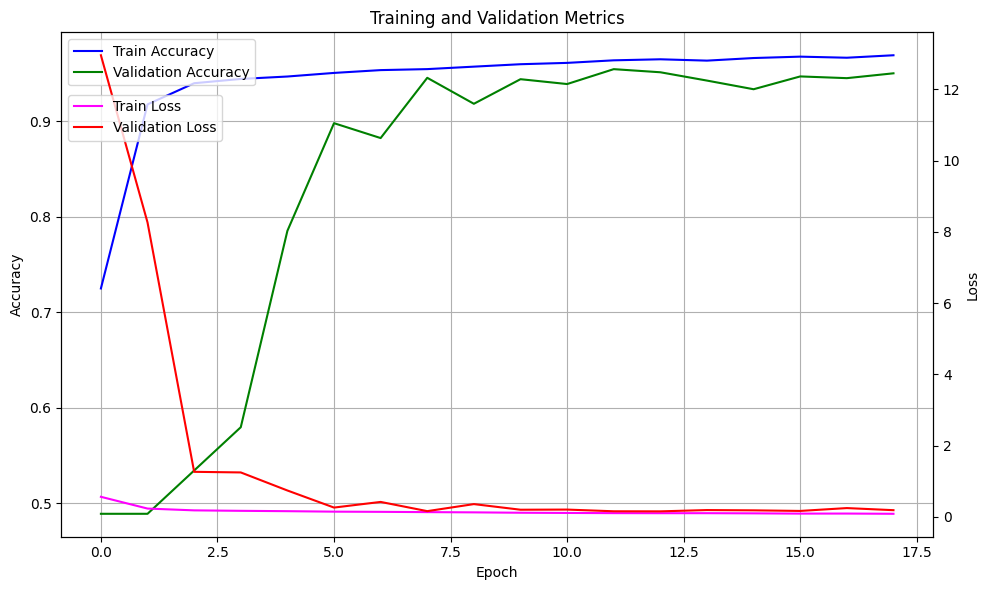

In [50]:
mu.plot_training_history(history)


## 7. Predict model Output for Test Data

- Use the trained model to make predictions on the test data.
- Inspect images randomly for the mismatch between actual and predicted labels

In [51]:
actual_images, actual_labels, predicted_labels = mu.extract_labels_predictions(model, test_dataset_preprocessed)

2024-07-20 14:19:13.004999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


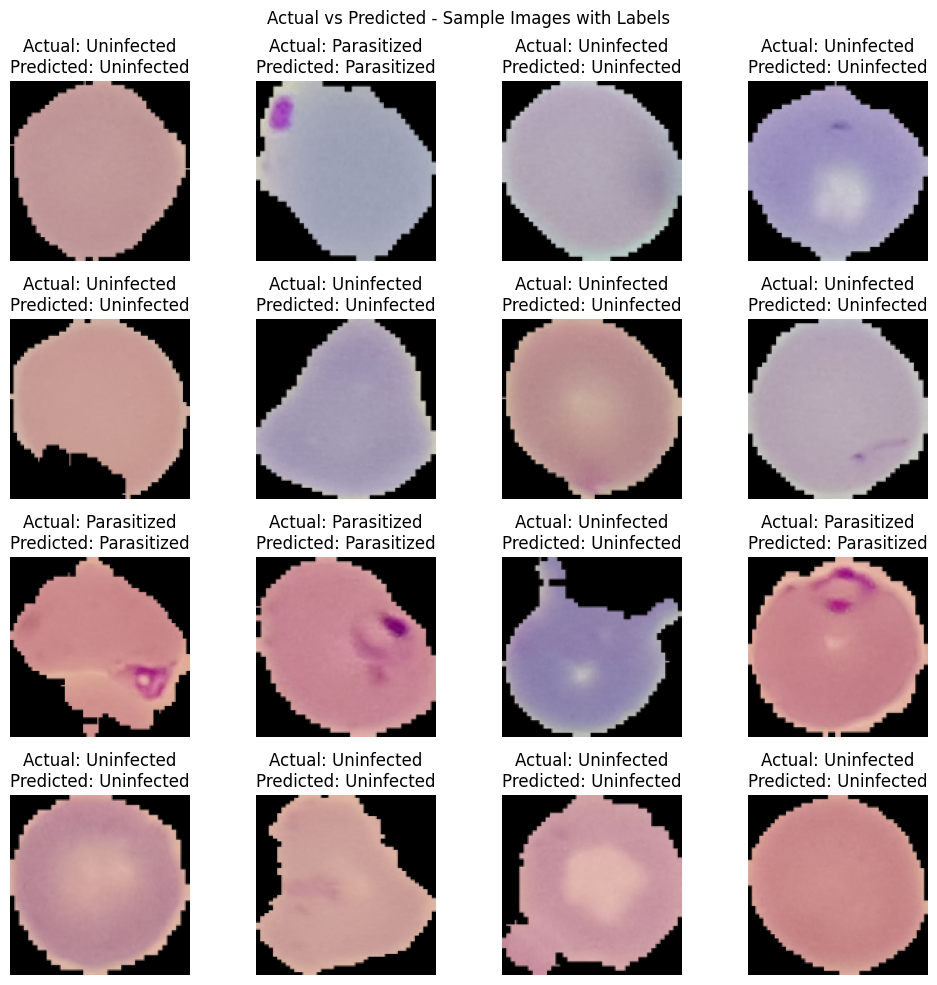

In [60]:
mu.show_actuals_predictions(actual_images, actual_labels, predicted_labels, 'Actual vs Predicted')


## 8. Measure model performance by various metrics

- Plot confusion matrix
- Find Accuracy, Precision, Recall and F1 Score
- Create a classification report 


Actual Labels of first ten samples: [0 0 1 0 1 1 1 1 1 0]
Prediction for corresponding samples: [0 0 1 0 1 1 1 1 1 0]



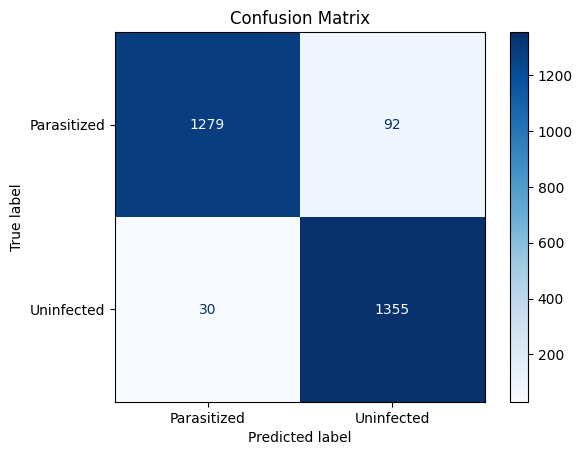


Accuracy: 0.9557
Precision: 0.9364
Recall: 0.9783
F1 Score: 0.9569


### Classification Report

```
              precision    recall  f1-score   support

 Parasitized       0.98      0.93      0.95      1371
  Uninfected       0.94      0.98      0.96      1385

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756

```

In [53]:
mu.eval_visualize_performance(actual_labels, predicted_labels)